In [1]:
import sys
sys.path.insert(1, '/home/sam/Documents/network/project/supernode')

In [2]:
from data.dataset import Dataset_tree_cycle, Dataset_tree_cycle_Memory
from data.dataloader import create_dataloader
from models.procedure import train, test
from concepts.concepts import *
from concepts.transformations import AddSupernodes

In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

def visualize(g, transf, set_labels=None):
    if set_labels:
        set_labels = nx.get_node_attributes(g, set_labels) 
        
    if transf:
        ntype = set(nx.get_node_attributes(g, "ntype").values())
        ntype.remove('ORIG')
        
        nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), 
                     node_color=['#1f78b4' if n=='ORIG' else '#1fffff' for n in nx.get_node_attributes(g, "ntype").values()],
                     labels = set_labels
                    )
    else:
        nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), labels = set_labels)

def showConcepts(g, k, v):
    N = list(g.neighbors(k))
    N.append(k)
    
    print(list(g.neighbors(k)), v, k)
    nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), 
                 node_color=['#1fffff' if n in N else '#1f78b4' for n in nx.nodes(g)]                    )
    plt.show()



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# IMPORT DATASET

In [6]:
dataset = Dataset_tree_cycle_Memory(root="./dataset/simple",
                                    dataset_path="/home/sam/Documents/network/project/dataset/simple",
                                    )

In [7]:
data = dataset[0]

In [8]:
g = to_networkx(data, to_undirected=True, node_attrs=["x"], graph_attrs=["y"])

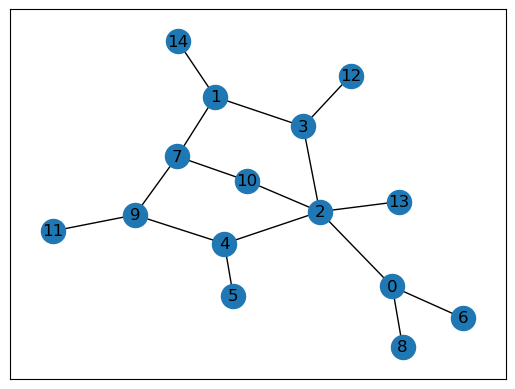

In [9]:
visualize(g, False)

# TRANSFORM DATASET

In [10]:
concepts_list_ex = [
       {"name": "GCB", "fun": cycle_basis, "args": []},
       {"name": "GMC", "fun": max_cliques, "args": []},
       {"name": "GLP2", "fun": line_paths, "args": [2]}
    ]

dataset.transform = AddSupernodes(concepts_list_ex)

In [11]:
data = dataset[0]

In [12]:
g = to_networkx(data, to_undirected=True, node_attrs=["x", "ntype"], graph_attrs=["y"])

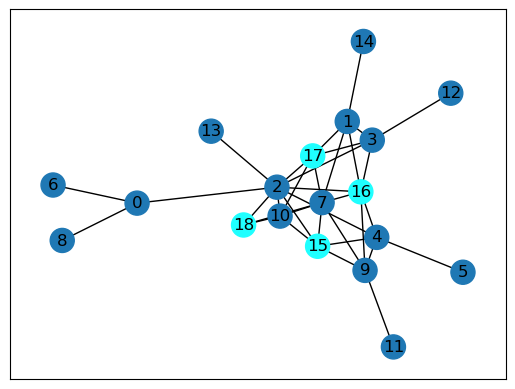

In [13]:
visualize(g, True)

## CONCEPTS AND SUPERNODE VISUALIZATION

[2, 4, 7, 9, 10] GCB 15


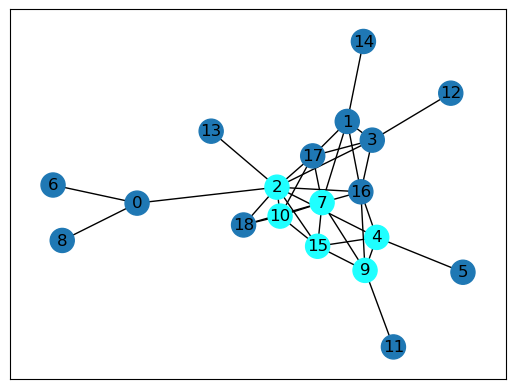

[1, 2, 3, 4, 7, 9] GCB 16


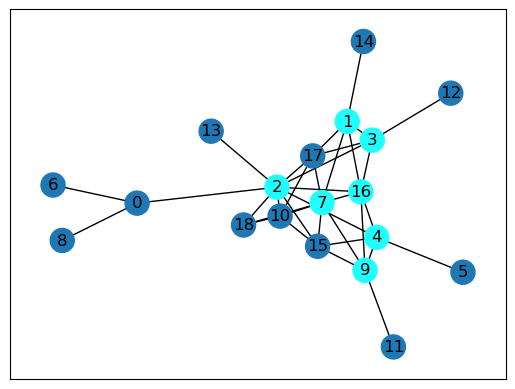

[1, 2, 3, 7, 10] GCB 17


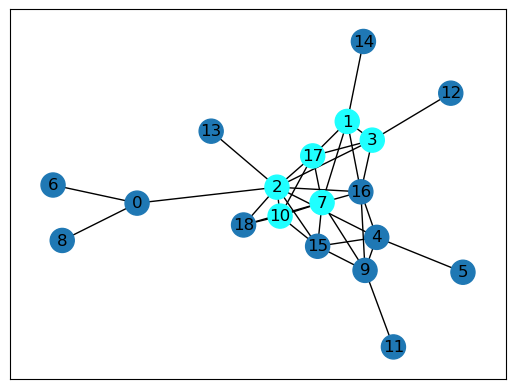

[2, 7, 10] GLP2 18


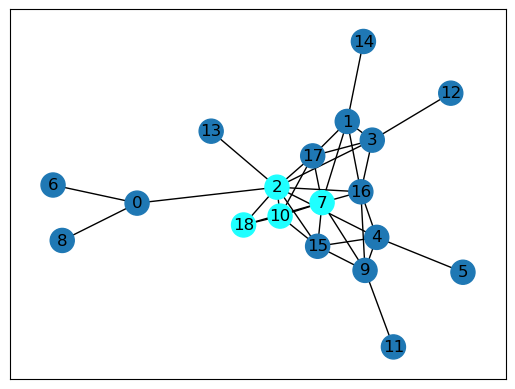

In [14]:
for k, v in nx.get_node_attributes(g, "ntype").items():
    if v != 'ORIG':
        showConcepts(g, k, v)

In [15]:
data

Data(x=[19, 1], edge_index=[2, 70], y=[1], ntype=[19], S=[19], edge_S=[70])

In [16]:
x = data.x
supernode_mask = data.S > 0
edge_mask = data.edge_S > 0

In [17]:
from torch_geometric.nn import SimpleConv
sc = SimpleConv("sum")

x2 = sc(x, data.edge_index, edge_mask)
x[supernode_mask] = x2[supernode_mask]
print(x)
print(len(x))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [5.],
        [6.],
        [5.],
        [3.]])
19


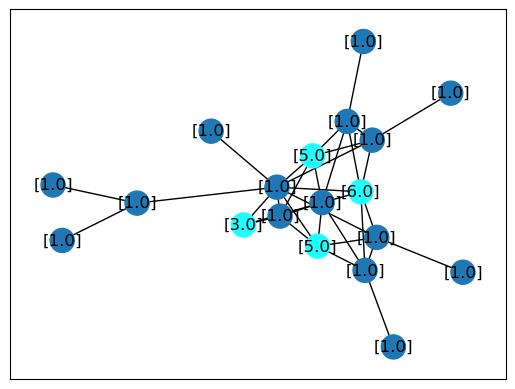

In [18]:
from torch_geometric.data import Data

data.x = x
G = to_networkx(data, to_undirected=True, node_attrs=["x", "ntype"])
visualize(G, True, "x")

In [19]:
#data = next(iter(loader))

In [20]:
data

Data(x=[19, 1], edge_index=[2, 70], y=[1], ntype=[19], S=[19], edge_S=[70])

IDEAS
- add a mask for each supernode of the entire graph (problem: don't know which supernode update)
- add a mask for each supernode of the specific nodes 
- apply the message passing only on certain nodes: mask of the supernodes + neighbours update (require custom message passing)
- (THIS) apply message passing on a sub edge_index (only edge containing supernodes), update only the supernodes with a mask

## NORMAL NODE CONV

In [21]:
dataset = Dataset_tree_cycle_Memory(root="./dataset/simple",
                                    dataset_path="/home/sam/Documents/network/project/dataset/simple",
                                    )
concepts_list_ex = [
       {"name": "GCB", "fun": cycle_basis, "args": []},
       {"name": "GMC", "fun": max_cliques, "args": []},
       {"name": "GLP2", "fun": line_paths, "args": [2]}
    ]

dataset.transform = AddSupernodes(concepts_list_ex)

In [22]:
data = dataset[0]

In [23]:
g = to_networkx(data, to_undirected=True, node_attrs=["x", "ntype"], graph_attrs=["y"])

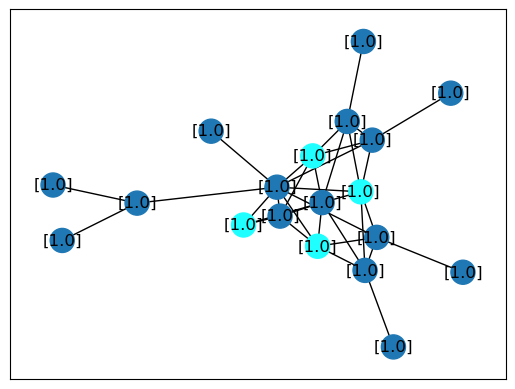

In [24]:
visualize(g, True, "x")

In [25]:
x = data.x
supernode_mask = data.S <= 0
edge_mask = data.edge_S <= 0

In [26]:
from torch_geometric.nn import SimpleConv
sc = SimpleConv("sum")

x2 = sc(x, data.edge_index)
x[supernode_mask] = x2[supernode_mask]

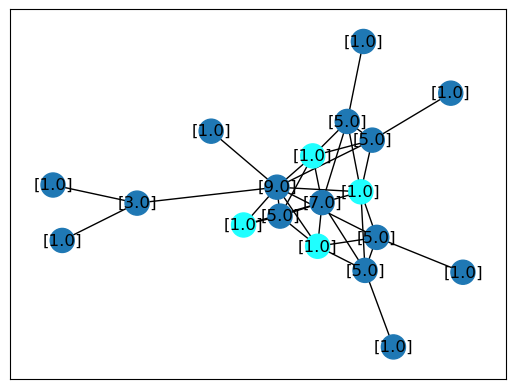

In [27]:
from torch_geometric.data import Data

data.x = x
G = to_networkx(data, to_undirected=True, node_attrs=["x", "ntype"])
visualize(G, True, "x")

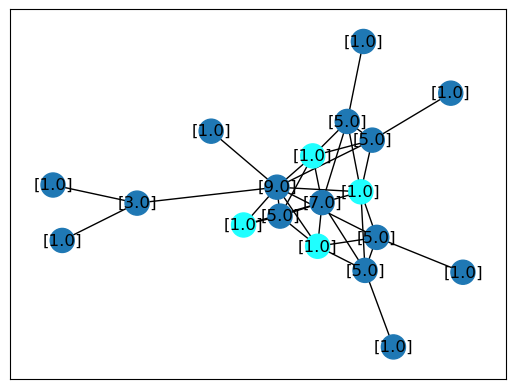

In [28]:
from torch_geometric.data import Data

data.x = x
G = to_networkx(data, to_undirected=True, node_attrs=["x", "ntype"])
visualize(G, True, "x")